# Example of THz TDS transmission data analysis
This should be a general approach to transmission TDS using the thzsoftware library.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from thzsoftware import data as d
from thzsoftware.tds import pulse as pl
from thzsoftware.tds import phase as ph
from thzsoftware import math as mt

In [3]:
plt.rcParams["figure.figsize"] = (24,8)

## Load data
To automatically load data, we construct the *DataSet* class contained in *thzsoftware.data*. This class looks for directories, e.g. for measurement days in the supplied data directory, then for files within that subdirectory. These are ordered in a dictionary built as follows:

set = {data_directory:{file_name:{type]}}

The type option is given, such that one easily can save different dataframes with the same measurement name. In this case we initially load a time trace, calling the type "time". Later, we will compute a fourier transform, saving it with the same measurement name and the type "spectrum".

In [4]:
data_set = d.DataSet("./example data/transmission","time")
keys = data_set.keys
directory = list(keys.keys())[0]
air_file = list(keys[directory].keys())[0]
Si_file = list(keys[directory].keys())[1]

print("Keys for displaying data: ", data_set.keys)
data_set.data[directory][Si_file]["time"]

Keys for displaying data:  {'test_data': {'air.pulse': 'time', 'Si.pulse': 'time'}}


,Time_abs/ps,Signal 1/nA,Signal 2/nA
0,1878.00,0.039636,0.026090
1,1878.05,-0.022806,0.029124
2,1878.10,0.001383,-0.017295
3,1878.15,0.001508,-0.008982
4,1878.20,-0.019721,-0.028937
...,...,...,...
1996,1977.80,0.532191,-0.006440
1997,1977.85,0.590169,-0.027398
1998,1977.90,0.533102,-0.007998
1999,1977.95,0.407797,0.013719


### Plotting:

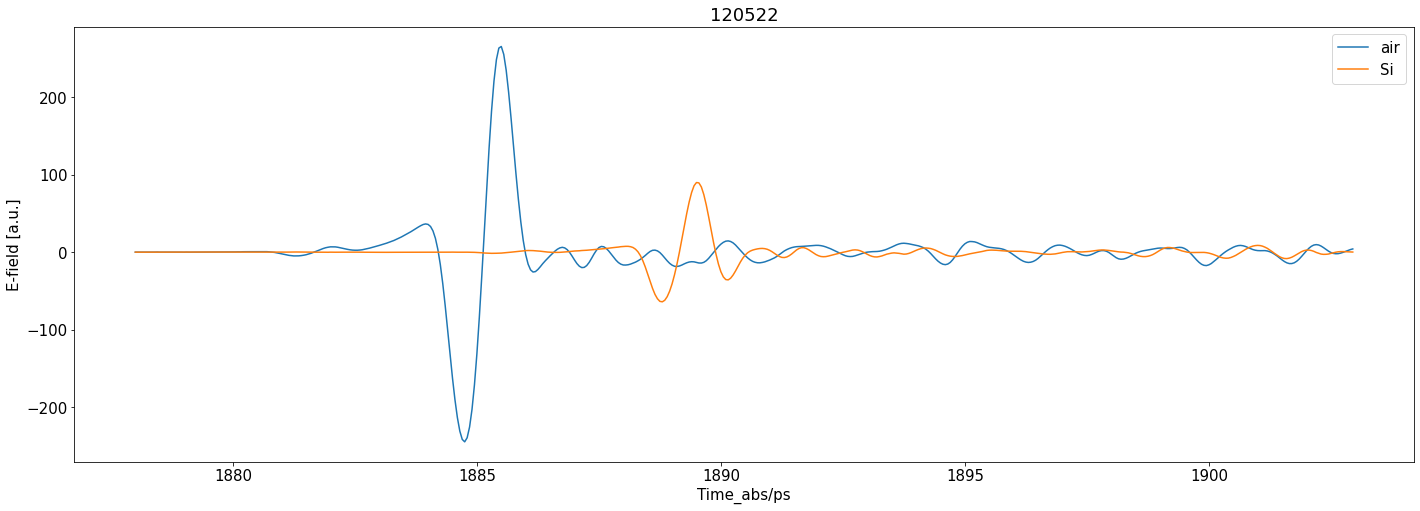

In [5]:
plt.figure()
plt.rc('font', size=15)
axes = plt.axes(ylabel="E-field [a.u.]")
data_set.data[directory][air_file]["time"].iloc[:500].plot(x=0,y=1, figsize=(24, 8), title='120522', ax=axes)
data_set.data[directory][Si_file]["time"].iloc[:500].plot(x=0,y=1, figsize=(24, 8), ax=axes)
axes.legend(["air", "Si"])
plt.show()

# Refractive index by phase shift

## Apply window function
As can be seen in the plot above, the time traces for both air and silicon are very noise. To get rid of this, we find the peaks, and apply a Tukey window around both of them.
For this we will start by extracting the data into arrays.

In [6]:
air_times_array = data_set.data[directory][air_file]["time"].iloc[:, 0].values
air_signal_array = data_set.data[directory][air_file]["time"].iloc[:, 1].values

Si_times_array = data_set.data[directory][Si_file]["time"].iloc[:, 0].values
Si_signal_array = data_set.data[directory][Si_file]["time"].iloc[:, 1].values

The *pulse.define_thz_pulses* function can limit our pulses, so that windowing them becomes trivial:

In [7]:
air_limits = pl.define_thz_pulses(air_signal_array)
Si_limits = pl.define_thz_pulses(Si_signal_array)

air_window = pl.window(air_signal_array, air_limits, window_func="tukey")
Si_window = pl.window(Si_signal_array, Si_limits, window_func="tukey")

Insert into dataframes:

In [8]:
data_set.data[directory][air_file]["time"].iloc[:, 1] = air_window
data_set.data[directory][Si_file]["time"].iloc[:, 1] = Si_window

### Plotting:

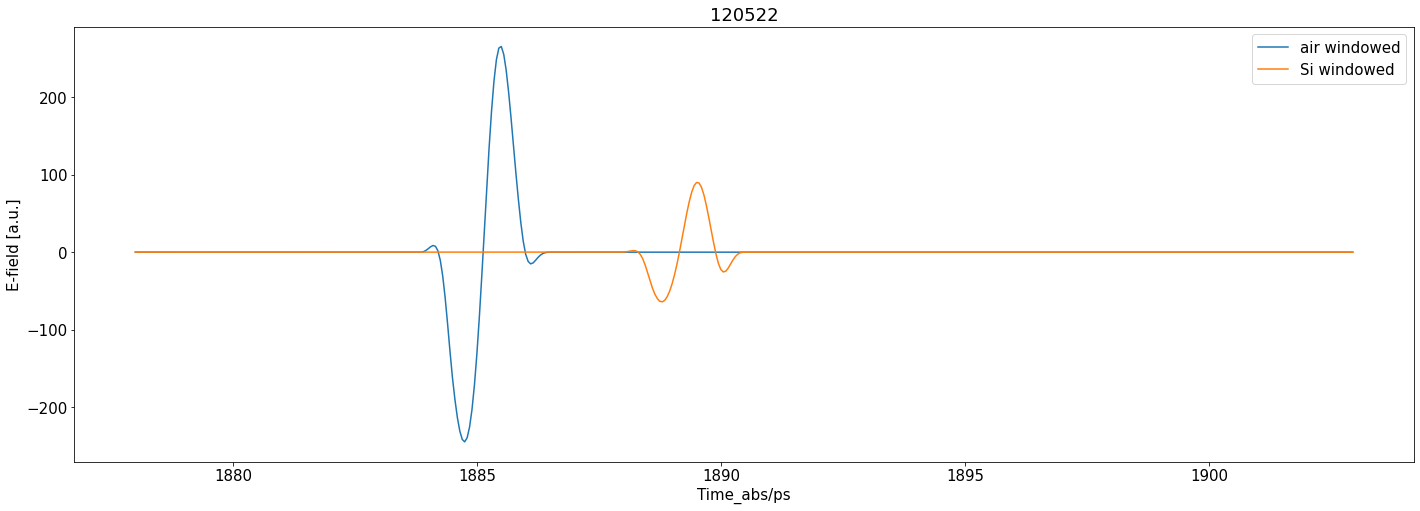

In [9]:
plt.figure()
plt.rc('font', size=15)
axes = plt.axes(ylabel="E-field [a.u.]")
data_set.data[directory][air_file]["time"].iloc[:500].plot(x=0,y=1, figsize=(24, 8), title='120522', ax=axes)
data_set.data[directory][Si_file]["time"].iloc[:500].plot(x=0,y=1, figsize=(24, 8), ax=axes)
axes.legend(["air windowed", "Si windowed"])
plt.show()

## Fourier transform
We do the transform on the windowed function, and save it as a data frame:

In [10]:
sample_rate_air = 1 / ((air_times_array[1] - air_times_array[0]) * 1e-12)
sample_rate_Si = 1 / ((Si_times_array[1] - Si_times_array[0]) * 1e-12)
air_frequencies, air_spectrum = ph.fft(air_signal_array, sample_rate_air, pad=500)
Si_frequencies, Si_spectrum = ph.fft(Si_signal_array, sample_rate_Si, pad=500)

# compute phase and norm. The 'compute_phase()' function unwraps the phase by default.
# To avoid this, set the default value 'unwrap_phase' to False

air_norm, air_phase = ph.compute_phase(air_spectrum)
Si_norm, Si_phase = ph.compute_phase(Si_spectrum)

To add a dataframe, we use the *.addentry()* method of our *Data* object. This method takes a directroy key, data key and type key, follwed by a tuple containing a column title and an array containing data points.

In [11]:
data_air = (("frequencies [Hz]", air_frequencies), ("Norm [a.u.]", air_norm), ("Phase [a.u.]", air_phase))
data_Si = (("frequencies [Hz]", Si_frequencies), ("Norm [a.u.]", Si_norm), ("Phase [a.u.]", Si_phase))

data_set.add_entry(directory, air_file, "spectrum", data_air)
data_set.add_entry(directory, Si_file, "spectrum", data_Si)

### Plotting:

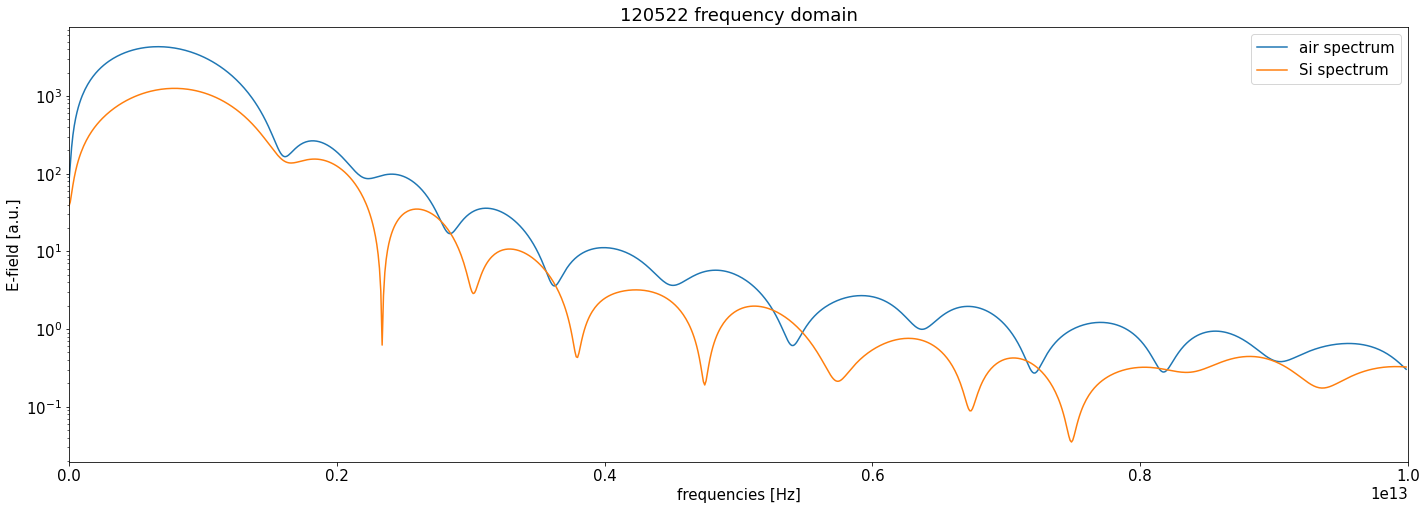

In [12]:
plt.figure()
plt.rc('font', size=15)
axes = plt.axes(ylabel="E-field [a.u.]")
data_set.data[directory][air_file]["spectrum"].plot(x=0,y=1, figsize=(24, 8), title='120522 frequency domain', ax=axes, logy=True)
data_set.data[directory][Si_file]["spectrum"].plot(x=0,y=1, figsize=(24, 8), ax=axes, logy=True)
axes.legend(["air spectrum", "Si spectrum"])
axes.set_xlim((0, 10*1e12))
plt.show()

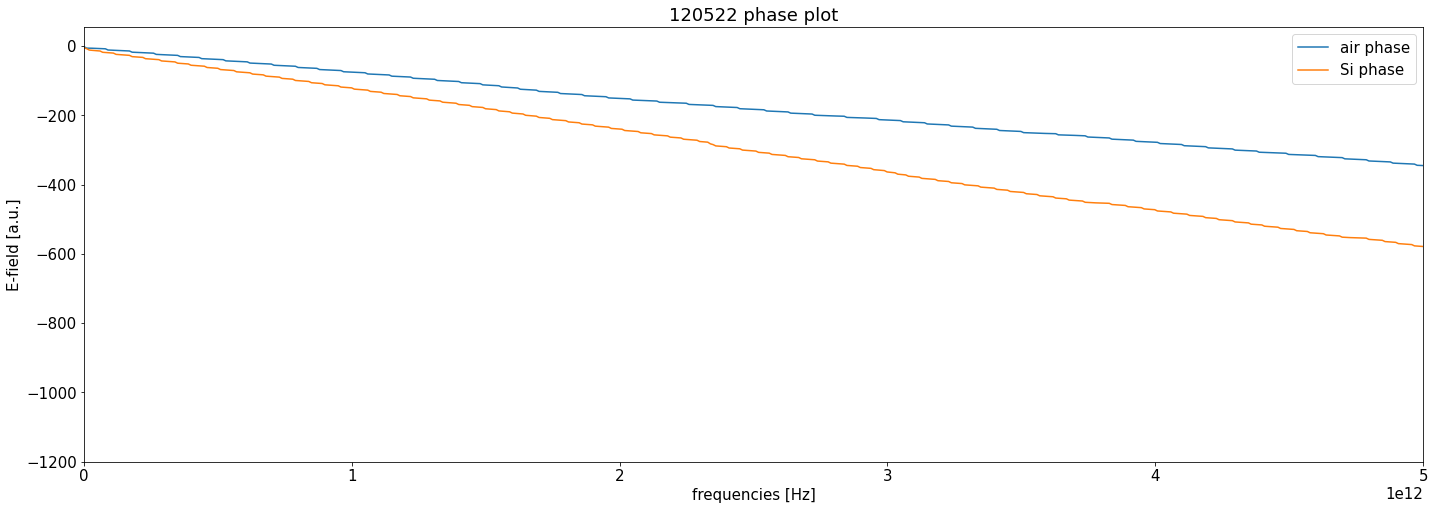

In [13]:
plt.figure()
plt.rc('font', size=15)
axes = plt.axes(ylabel="E-field [a.u.]")
data_set.data[directory][air_file]["spectrum"].plot(x=0,y=2, figsize=(24, 8), title='120522 phase plot', ax=axes)
data_set.data[directory][Si_file]["spectrum"].plot(x=0,y=2, figsize=(24, 8), ax=axes)
axes.legend(["air phase", "Si phase"])
axes.set_xlim((0, 5*1e12))
plt.show()

### Getting rid of the non-linearity
To get rid of the non-linearity close to f = 0, we use the *extrapolate_phase()* function:

In [19]:
f_limits = (.5*1e12, 3*1e12)
air_phase = ph.extrapolate_phase(air_frequencies, air_phase, f_limits)
Si_phase = ph.extrapolate_phase(Si_frequencies, Si_phase, f_limits)
data_set.data[directory][air_file]["spectrum"]["Phase [a.u.]"] = air_phase
data_set.data[directory][Si_file]["spectrum"]["Phase [a.u.]"] = Si_phase

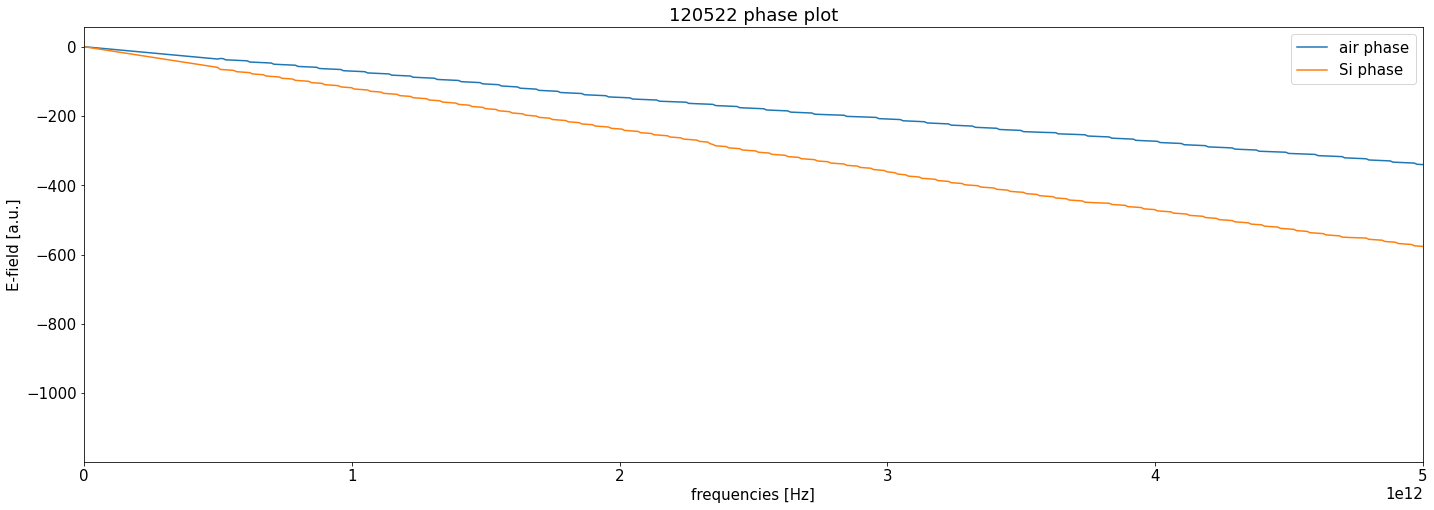

In [20]:
plt.figure()
plt.rc('font', size=15)
axes = plt.axes(ylabel="E-field [a.u.]")
data_set.data[directory][air_file]["spectrum"].plot(x=0,y=2, figsize=(24, 8), title='120522 phase plot', ax=axes)
data_set.data[directory][Si_file]["spectrum"].plot(x=0,y=2, figsize=(24, 8), ax=axes)
axes.legend(["air phase", "Si phase"])
axes.set_xlim((0, 5*1e12))
plt.show()

## Compute refractive index
Using the cleaned up phase information, we now can compute the index of refraction and add it to the data frame.

In [21]:
n_Si = ph.compute_n_by_phase(Si_frequencies, air_phase, Si_phase, 525*1e-6)
data_Si = (("frequencies [Hz]", Si_frequencies), ("n", n_Si))
data_set.add_entry(directory, Si_file, "n", data_Si)

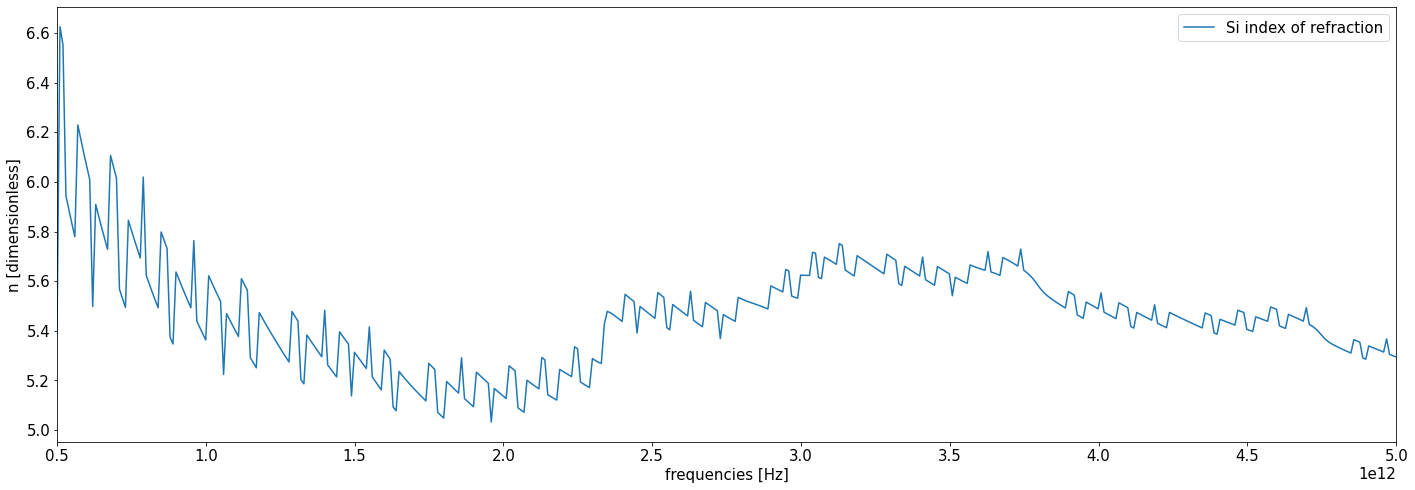

In [25]:
plt.figure()
plt.rc('font', size=15)
axes = plt.axes(ylabel="n [dimensionless]")
data_set.data[directory][Si_file]["n"].plot(x=0,y=1, figsize=(24, 8), ax=axes)
axes.legend(["Si index of refraction"])
axes.set_xlim((.5*1e12, 5*1e12))
plt.show()

## Save output to .csv
Finally, we can save the programs output to a .csv file. Passing no path kwarg just creates a directory name "{data_path} + _output".

In [18]:
data_set.save_to_csv()

Target output set to ./example data/transmission_output
Target directory is non-empty. Continuing risks overwriting data in directories of the same name.
